<font size = "5"> **EELS_Tools:  [Spectroscopy](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of EDS Spectra
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Spectroscopy/EDS.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Spectroscopy/EDS.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package



Notebook by Gerd Duscher, 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into displaying and analyzing EDS spectrum images and spectra
This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [22]:
import sys
import importlib.metadata

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2026.02.0':
    print('installing pyTEMlib')
   
    !{sys.executable} -m pip install pyTEMlib -q --upgrade

# ------------------------------
print('done')

installing pyTEMlib
done


### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.



In [178]:
def get_absorption(z, thickness, energy_scale):
    """ Calculate absorption for material with atomic number z and thickness t in m"""
    x_sections = pyTEMlib.eels_tools.get_x_sections()
    photoabsorption = x_sections[str(z)]['dat']/1e10/x_sections[str(z)]['photoabs_to_sigma']
    lin = scipy.interpolate.interp1d(x_sections[str(z)]['ene'], photoabsorption, kind='linear')
    mu = lin(energy_scale) * x_sections[str(z)]['nominal_density']*100  #1/cm -> 1/m
    return np.exp(-mu * thickness)

def get_absorption_correction(spectrum, thickness=50):
    """
    Calculate absorption correction for all elements in the spectrum based on thickness t in nm
    Updates the element in spectrum.metadata['EDS']['GUI'] dictionary
    Parameters:
    - spectrum: A sidpy.Dataset object containing the spectral data and metadata.
    - t: Thickness in nm
    Returns:
        None
    """
    start_channel = np.searchsorted(spectrum.energy_scale.values, 120)
    absorption = spectrum.energy_scale.values[start_channel:]*0.
    take_off_angle = spectrum.metadata['EDS']['detector'].get('ElevationAngle', 0)
    path_length = thickness / np.cos(take_off_angle) * 1e-9 # /2?    in m
    count = 1
    for element, lines in spectrum.metadata['EDS']['GUI'].items():
        part = lines['atom%']/100
        if part > 0 :
            count += 1
        absorption += get_absorption(pyTEMlib.utilities.get_atomic_number(element), path_length*part, spectrum.energy_scale[start_channel:])
        
    for element, lines in spectrum.metadata['EDS']['GUI'].items():    
        symmetry = 'K-family' # lines['symmetry']
        peaks = spectrum.metadata['EDS'][element][symmetry]['peaks'][start_channel:] *absorption/count
        lines['absorption'] = peaks.sum()
        lines['thickness'] = thickness


def apply_absorption_correction(spectrum, thickness):
    """ 
    Apply Absorption Correction to Quantification
    Updates the element in spectrum.metadata['EDS']['GUI'] dictionary
    Parameters:
    - spectrum: A sidpy.Dataset object containing the spectral data and metadata.
    - thickness: Thickness in nm
    Returns:
        None
    """
    get_absorption_correction(spectrum, thickness)

    atom_sum = 0.
    weight_sum = 0.
    for element, lines in spectrum.metadata['EDS']['GUI'].items():
        atom_sum += lines['atom%'] / lines['absorption']
        weight_sum += lines['weight%'] / lines['absorption']
    for element, lines in spectrum.metadata['EDS']['GUI'].items():
        lines['corrected-atom%'] = lines['atom%'] / lines['absorption'] / atom_sum*100
        lines['corrected-weight%'] = lines['weight%'] / lines['absorption'] / weight_sum*100

        
apply_absorption_correction(spectrum, 10)
spectrum.metadata['EDS']['GUI']

{'Sr': {'symmetry': 'K-family',
  'atom%': np.float64(21.874148275996262),
  'weight%': np.float64(49.34479120909743),
  'excluded': False,
  'k_factor': 1.399,
  'intensity': np.float64(18844.421973298482),
  'absorption': np.float64(0.9999863920332281),
  'thickness': 10,
  'corrected-atom%': np.float64(21.77723396845126),
  'corrected-weight%': np.float64(49.25368531911303)},
 'Cu': {'atom%': 0,
  'weight%': 0,
  'excluded': True,
  'k_factor': 0.513247,
  'intensity': np.float64(8228.632710522863),
  'absorption': np.float64(0.9999332315422246),
  'thickness': 10,
  'corrected-atom%': np.float64(0.0),
  'corrected-weight%': np.float64(0.0)},
 'Ti': {'symmetry': 'K-family',
  'atom%': np.float64(22.507241504278543),
  'weight%': np.float64(27.744910478867833),
  'excluded': False,
  'k_factor': 0.379229,
  'intensity': np.float64(39087.780103385885),
  'absorption': np.float64(0.9998966161564367),
  'thickness': 10,
  'corrected-atom%': np.float64(22.409534114273317),
  'corrected-w

In [164]:
np.searchsorted(spectrum.energy_scale.values, 120)

np.int64(37)

In [128]:
spectrum.metadata['EDS']['GUI']
np.degrees(spectrum.metadata['EDS']['detector']['ElevationAngle'])



np.float64(18.0000002659109)

In [1]:
%matplotlib widget
import numpy as np
import scipy

import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

%load_ext autoreload
%autoreload 2
import sys 
sys.path.insert(0, '../../')
import pyTEMlib.eds_xsections
import pyTEMlib

# using  pyTEMlib.eds_tools, pyTEMlib.file_tools and pyTEMlib.eels_tools (for line definitions)
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = 'EDS_Spectrum_Analysis'
__notebook_version__ = '2025_09_23'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
pyTEM version:  0.2025.09.3


In [3]:
import SciFiReaders
SciFiReaders.__version__

'0.12.2'

## Open File

### Load File

Select a main dataset and any additional data like reference data and such.

In [5]:
help(pyTEMlib.file_tools.FileWidget)

Help on class FileWidget in module pyTEMlib.file_tools:

class FileWidget(sidpy.io.interface_utils.FileWidget)
 |  FileWidget(dir_name=None, extension=['*'], sum_frames=False)
 |
 |  Widget to select directories or widgets from a list
 |
 |  Works in google colab.
 |  The widget converts the name of the nion file to the one in Nion's swift software,
 |  because it is otherwise incomprehensible
 |
 |  Attributes
 |  ----------
 |  dir_name: str
 |      name of starting directory
 |  extension: list of str
 |      extensions of files to be listed  in widget
 |
 |  Methods
 |  -------
 |  get_directory
 |  set_options
 |  get_file_name
 |
 |  Example
 |  -------
 |  >>from google.colab import drive
 |  >>drive.mount("/content/drive")
 |  >>file_list = pyTEMlib.file_tools.FileWidget()
 |  next code cell:
 |  >>datasets = file_list.datasets
 |  >>dataset = file_list.selected_dataset
 |
 |  Method resolution order:
 |      FileWidget
 |      sidpy.io.interface_utils.FileWidget
 |      builti

In [17]:
fileWidget = pyTEMlib.file_tools.FileWidget(extension='.txt')


In [14]:

data_chooser = pyTEMlib.file_tools.ChooseDataset(fileWidget.datasets)

Dropdown(description='select dataset:', options=('Channel_000: 01-EELS Acquire_STO', 'Channel_001: EELS_STO2',…

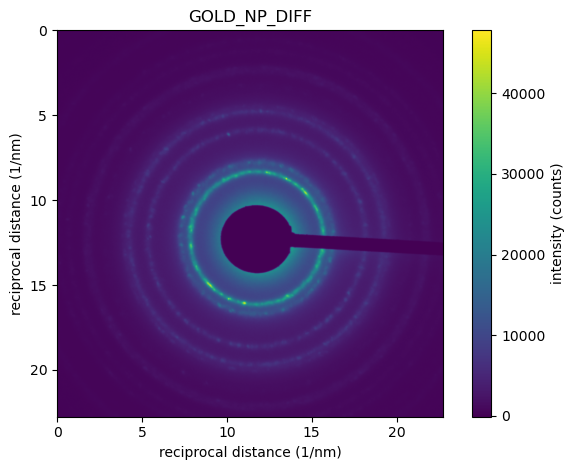

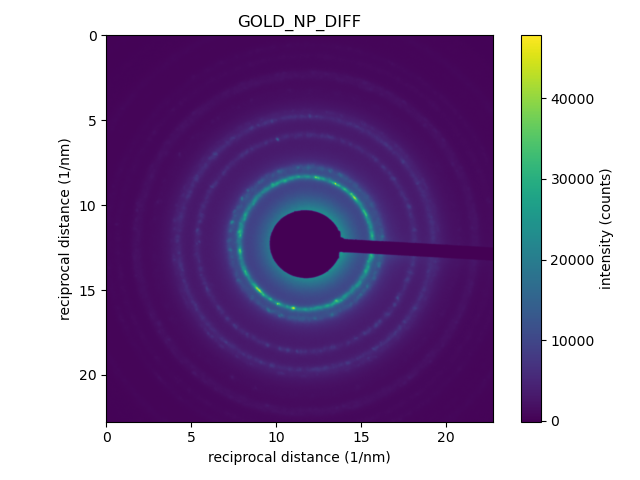

In [15]:
data_chooser.dataset.plot()

### Select and Plot Dataset

Select a dataset from the drop down value and display it with the code cell below.

Here we sum the spectra of the 4 quadrants and define the detector parameter.

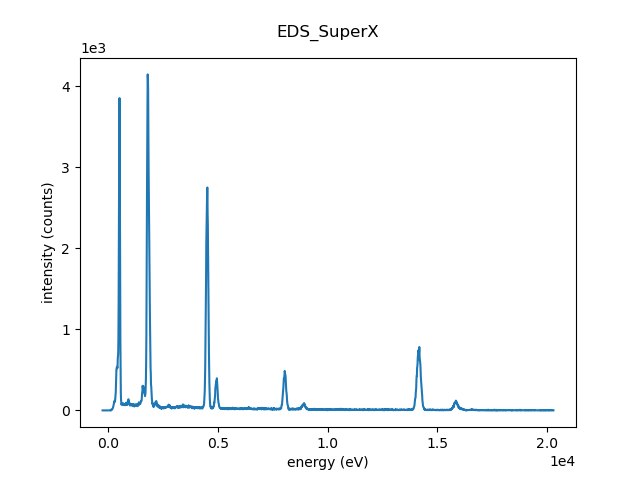

In [3]:
spectrum = fileWidget.selected_dataset
import pyTEMlib.eds_xsections
start = np.searchsorted(spectrum.energy_scale.values, 100)
energy_scale = spectrum.energy_scale.values[start:]
detector_Efficiency= pyTEMlib.eds_tools.detector_response(spectrum)  # tags, spectrum.energy_scale.values[start:])
if 'start_energy' not in spectrum.metadata['EDS']['detector']:
    spectrum.metadata['EDS']['detector']['start_energy'] = 120
spectrum[:np.searchsorted(spectrum.energy_scale.values,spectrum.metadata['EDS']['detector']['start_energy'])] = 0.
spectrum.metadata['EDS']['detector']['detector_efficiency']  = detector_Efficiency
view = spectrum.plot()

In [10]:
import importlib.resources

data_dir = importlib.resources('package.data')
data_path = Path(data_dir , 'data.csv')

TypeError: 'module' object is not callable

## Find Elements 

C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\array\core.py:1744: FutureWarning: The `numpy.argsort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


['Ti', 'O', 'Sr', 'Cu']


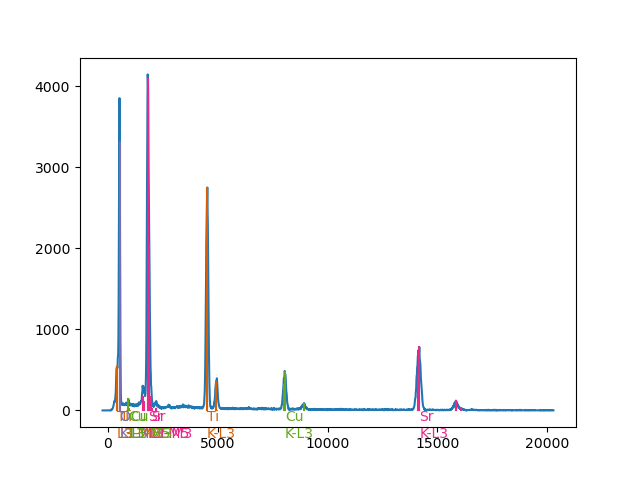

In [4]:
# --------Input -----------
minimum_number_of_peaks = 10
# --------------------------
minor_peaks = pyTEMlib.eds_tools.detect_peaks(spectrum, minimum_number_of_peaks=minimum_number_of_peaks)

keys = list(spectrum.metadata['EDS'].keys())
for key in keys:
    if len(key) < 3:
        del spectrum.metadata['EDS'][key]

elements = pyTEMlib.eds_tools.find_elements(spectrum, minor_peaks)

print(elements) 
spectrum.metadata['EDS'].update(pyTEMlib.eds_tools.get_x_ray_lines(spectrum, elements))
plt.figure()
plt.plot(spectrum.energy_scale,spectrum, label = 'spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())


## Quantify

### Fit spectrum

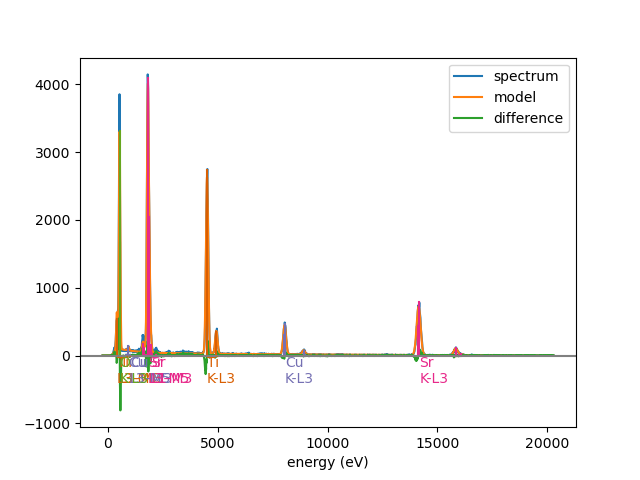

In [6]:
peaks, pp = pyTEMlib.eds_tools.fit_model(spectrum, use_detector_efficiency=True)
model = pyTEMlib.eds_tools.get_model(spectrum)

plt.figure()
plt.plot(spectrum.energy_scale, spectrum, label='spectrum')
plt.plot(spectrum.energy_scale, model, label='model')
plt.plot(spectrum.energy_scale, spectrum-model, label='difference')
plt.xlabel('energy (eV)')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.axhline(y=0, xmin=0, xmax=1, color='gray')
plt.legend()

### Quantify Spectrum
first with Bote-Salvat cross section

In [12]:
pyTEMlib.eds_tools.quantify_EDS(spectrum, mask =['Cu'])

using cross sections for quantification
x 5.274032561010808e-07
x 7.264054130304e-09
x 4.482132489558731e-09
Ti: 98.64 at% 98.57 wt%
Sr: 0.65 at% 1.20 wt%
O : 0.71 at% 0.24 wt%


In [10]:
import pyTEMlib.eds_xsections

In [304]:
q_dict = pyTEMlib.eds_tools.load_k_factors()
tags = pyTEMlib.eds_tools.quantify_EDS(spectrum, q_dict, mask = ['Cu'])

using k-factors for quantification
Sr: 21.87 at% 49.34 wt%
Ti: 22.51 at% 27.74 wt%
O : 55.62 at% 22.91 wt%
excluded from quantification  ['Cu']


In [22]:
shell = 'L'
x_sections = pyTEMlib.eels_tools.get_x_sections()
total_rates = 0
for key, line in x_sections['22']['lines'].items():
    if key[0] == shell[0]:
     total_rates += line.get('weight', 0)
total_rates

x_sections['22']['lines']

{'K-L3': {'weight': 1.0, 'position': 4510.900000000001},
 'K-L2': {'weight': 0.509, 'position': 4504.900000000001},
 'K-M3': {'weight': 0.128, 'position': 4931.8},
 'K-M2': {'weight': 0.0733, 'position': 4931.8},
 'L3-M1': {'weight': 0.556, 'position': 395.2},
 'L2-M3': {'weight': 9.85e-05, 'position': 426.9},
 'L2-M1': {'weight': 0.272, 'position': 401.2},
 'L1-M3': {'weight': 0.00654, 'position': 529.0999999999999},
 'L1-M2': {'weight': 0.0173, 'position': 529.0999999999999}}

In [187]:
def get_bote_salvat_dict(z=0):
    filename = os.path.join(pyTEMlib.config_path, 'xrays_X_section_200kV.json')
    x_sections = json.load(open(filename))
    if z > 0:
        return x_sections['table'][str(z)]
    return x_sections
def get_line_strength(z, shell):
    x_section =  get_bote_salvat_dict(z)
    cs = 0
    for key,item in x_section.items():
        if key[0] == shell[0]:
            cs+= item['cs']
    return cs
    

In [295]:
o = {}
total = 0.
for key, item in spectrum.metadata['EDS']['GUI'].items():
    if key == 'Cu':
        print(key, ' excluded')
        continue
    intensity = item['intensity']
    z = pyTEMlib.utilities.get_z(key)
    cs = get_line_strength(z, 'K')
    print(key, cs*10e21, intensity,  intensity/ cs*10e-21)
    p_k = (spectrum.metadata['EDS'][key]['K-family']['peaks'][37:]*absorption).sum()
    
    o[key] = intensity/ cs*10e-21
    total += intensity/ cs*10e-21
for key in o:
    print(key, o[key]/total)

Sr 0.7368982518069231 18844.421973298482 2557262.4072713857
Cu  excluded
Ti 1.1060835598434287 39087.780103385885 3533890.342689746
O 0.518801764331399 32912.01278683663 6343851.360885729
Sr 0.20973724492236007
Ti 0.28970663893524956
O 0.5005561161423905


In [296]:
cs_k =  get_line_strength(38, 'K')

cs_l = get_line_strength(38, 'L')
i_k = spectrum.metadata['EDS']['Sr']['K-family']['areal_density']
i_l = spectrum.metadata['EDS']['Sr']['L-family']['areal_density']
p_k = spectrum.metadata['EDS']['Sr']['K-family']['peaks']
p_l = spectrum.metadata['EDS']['Sr']['L-family']['peaks']
print(i_l, i_k, i_l/i_k,  cs_l / cs_k, i_k/cs_k / (i_l/cs_l))


thickness = 50
energy_scale = spectrum.get_spectral_dims(return_axis=True)[0].values
start_channel = np.searchsorted(energy_scale, 120)
absorption = energy_scale[start_channel:]*0.
take_off_angle = spectrum.metadata['EDS']['detector'].get('ElevationAngle', 0)
path_length = thickness / np.cos(take_off_angle) * 1e-9 # /2?    in m
count = 1

for element, lines in spectrum.metadata['EDS']['GUI'].items():
    part = lines['atom%']/100
    if part > 0 :
        count += 1
    absorption += get_absorption(pyTEMlib.utilities.get_atomic_number(element), path_length*part, 
                                 energy_scale[start_channel:])
p_k = (p_k[37:]*absorption).sum()
p_l = (p_l[37:]*absorption).sum()

print(p_k/4, p_l/4)
print( i_k*p_k/cs_k / (i_l*p_l/cs_l))

56215.654054666986 18844.421973298482 2.9831455766762973 2.2284490285451217 0.7470131682369896
0.9999319650300605 0.9977894163149879
0.7486172262452009


In [302]:
import pyTEMlib.eds_x_xsections

ModuleNotFoundError: No module named 'pyTEMlib.eds_x_xsections'

In [301]:
i_k = spectrum.metadata['EDS']['Sr']['K-family']['areal_density']
i_l = spectrum.metadata['EDS']['Sr']['L-family']['areal_density']

c_l = 2.1842328617436956e-22
c_k = 7.264054130304e-23
i_k/c_k / (i_l/c_l)

np.float64(1.007964919836851)

In [ ]:
c_l = 9.066969123053945e-21)
c_k = 7.264054130304e-23, 
f_k = 0.68792
f_l = 0.02409


In [3]:
x_sections

NameError: name 'x_sections' is not defined

In [ ]:
1
c_k, c_l

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[87], line 1
----> 1 c_k, c_l

NameError: name 'c_l' is not defined

1
import pyTEMlib.eds_x_xsections

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
Cell In[88], line 1
----> 1 import pyTEMlib.eds_x_xsections

ModuleNotFoundError: No module named 'pyTEMlib.eds_x_xsections'

1
shell_list[0] = 'K'
bote_salvat_xsection
8
Python 3 (ipykernel) | Idle
Mode: Command
Ln 14, Col 5
emission.ipynb
1

## Summary
The spectrum is modeled completely with background and characteristic peak-families.

Either 
- k-factors in a file (here from Spectra300) or
- Bothe-Salvat cross-sections
 
are used for quantification.

## Appendix
### Background
The determined background used for the model-based quantification is based on the detector effciency.

Note:

The detector efficiency is also used for the quantification model.
